In [1]:
library(tidyverse)
library(readxl)
library(lubridate)
library(patchwork)
# Set the print width to 120 characters
options(width = 120)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
meta_0010 = read_xlsx('../data/metadata/0010/20190130 BW, FI - Collab with Tune Pers Group.xlsx', range = "B1:I19") %>% 
  # Fill in missing Box IDs
  fill(`Box ID`) %>% 
  # Rename and format BW and FI columns
  rename(
    bw_i = `BW\r\n29/1-19\r\n16.30`,
    fw_i = `FI\r\n29/1-19\r\n16.30`,
    bw_f = `BW\r\n30/1-19\r\n8.30`,
    fw_f = `FI\r\n30/1-19\r\n8.30`,
    time_of_euthanasia = `Time of\r\neuthanization\r\n30/1-19`
  ) %>% 
  # Add diet column
  mutate(diet = case_when(
    `Animal ID` %in% 1:6 ~ "chow",
    `Animal ID` %in% 7:12 ~ "fast",
    `Animal ID` %in% 13:18 ~ "HFD"
  )) %>% 
mutate(diet = factor(diet, levels = c("chow", "fast", "HFD"))) %>%
  relocate(diet, .after = `Animal ID`) %>%
  # Convert all column names to lowercase and replace spaces with underscores
  rename_with(~ tolower(.) %>% 
                str_replace_all(., " ", "_")) %>%
   # Replace N/A with 0 and "-" with the value from the row above in FI columns
  mutate(across(starts_with("fw"), ~str_replace_all(., "N/A", "0"))) %>%
  mutate(across(starts_with("fw"), ~replace(., . == "-", NA_character_))) %>%
  mutate(across(starts_with("fw"), ~as.numeric(.))) %>%
  mutate(across(starts_with("fw"), ~ifelse(is.na(.), lag(.), .))) %>%
  mutate(box_id = as.factor(box_id)) %>%
  mutate(animal_id = as.factor(animal_id)) %>%
  mutate(time_of_euthanasia = time_of_euthanasia %>% str_replace(fixed('.'), ':') %>% paste0("2019-01-30 " , .) %>% ymd_hm ) %>%
  group_by(box_id) %>%
  mutate(experiment_start = min(time_of_euthanasia) - hours(16)) %>%
  relocate(experiment_start, .before = time_of_euthanasia) %>%
  mutate(diet_kcal = case_when(diet == 'chow' ~ 3227,
                                 diet == 'fast' ~ 0,
                                 diet == 'HFD' ~ 5560)) %>%
  relocate(diet_kcal, .after=diet)

meta_0010

box_id,animal_id,diet,diet_kcal,bw_i,fw_i,bw_f,fw_f,experiment_start,time_of_euthanasia,notes
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dttm>,<chr>
34,1,chow,3227,23.4,741.7,24.6,734.4,2019-01-29 16:26:00,2019-01-30 08:26:00,NA
34,2,chow,3227,25.9,741.7,26.0,734.4,2019-01-29 16:26:00,2019-01-30 08:36:00,NA
35,3,chow,3227,26.2,743.5,26.4,735.3,2019-01-29 17:31:00,2019-01-30 09:31:00,NA
35,4,chow,3227,23.5,743.5,24.0,735.3,2019-01-29 17:31:00,2019-01-30 09:41:00,NA
36,5,chow,3227,24.7,713.6,24.4,706.4,2019-01-29 18:27:00,2019-01-30 10:27:00,NA
36,6,chow,3227,25.9,713.6,27.0,706.4,2019-01-29 18:27:00,2019-01-30 10:33:00,NA
37,7,fast,0,23.9,0.0,23.3,0.0,2019-01-29 16:49:00,2019-01-30 08:49:00,NA
37,8,fast,0,23.1,0.0,22.8,0.0,2019-01-29 16:49:00,2019-01-30 08:59:00,NA
38,9,fast,0,24.1,0.0,23.5,0.0,2019-01-29 17:50:00,2019-01-30 09:50:00,NA


In [3]:
directory <- "../data/02_aligned/0010"
file_list <- list.files(directory, full.names = TRUE)
filtered_list <- file_list %>%
  keep(str_ends, "ReadsPerGene.out.tab") %>%
  basename %>%
str_replace('_ReadsPerGene.out.tab', '')
filtered_list

[1] "1_Chow_Hip_left_S17"          "1_Chow_Hyp_both_S80"          "1_Chow_IC_left_S5"           
 [4] "1_Chow_PFC_left_S1"           "1_Chow_SC_left_S21"           "10_Fasting_Hip_right_S3"     
 [7] "10_Fasting_Hyp_both_S24"      "10_Fasting_IC_right_S2"       "10_Fasting_PFC_right_S62"    
[10] "10_Fasting_SC_right_S88"      "11_Fasting_Hip_right_S35"     "11_Fasting_Hyp_both_S30"     
[13] "11_Fasting_IC_right_S16"      "11_Fasting_PFC_right_S82"     "11_Fasting_SC_right_S40"     
[16] "12_Fasting_Hip_right_S77"     "12_Fasting_Hyp_both_S23"      "12_Fasting_IC_right_S37"     
[19] "12_Fasting_PFC_right_S52"     "12_Fasting_SC_right_S12"      "13_Highfatdiet_Hip_left_S73" 
[22] "13_Highfatdiet_Hyp_both_S57"  "13_Highfatdiet_IC_left_S81"   "13_Highfatdiet_PFC_left_S7"  
[25] "13_Highfatdiet_SC_left_S10"   "14_Highfatdiet_Hip_left_S50"  "14_Highfatdiet_Hyp_both_S28" 
[28] "14_Highfatdiet_IC_left_S58"   "14_Highfatdiet_PFC_left_S75"  "14_Highfatdiet_SC_left_S74"  
[31] "15_Highfatdiet_Hip_left_S27"  "15_Highfatdiet_Hyp_both_S18"  "15_Highfatdiet_IC_left_S55"  
[34] "15_Highfatdiet_PFC_left_S72"  "15_Highfatdiet_SC_left_S41"   "16_Highfatdiet_Hip_right_S8" 
[37] "16_Highfatdiet_Hyp_both_S85"  "16_Highfatdiet_IC_right_S46"  "16_Highfatdiet_PFC_right_S76"
[40] "16_Highfatdiet_SC_right_S59"  "17_Highfatdiet_Hip_right_S33" "17_Highfatdiet_Hyp_both_S26" 
[43] "17_Highfatdiet_IC_right_S29"  "17_Highfatdiet_PFC_right_S89" "17_Highfatdiet_SC_right_S64" 
[46] "18_Highfatdiet_Hip_right_S53" "18_Highfatdiet_Hyp_both_S13"  "18_Highfatdiet_IC_right_S70" 
[49] "18_Highfatdiet_PFC_right_S48" "18_Highfatdiet_SC_right_S90"  "2_Chow_Hip_left_S71"         
[52] "2_Chow_Hyp_both_S44"          "2_Chow_IC_left_S14"           "2_Chow_PFC_left_S63"         
[55] "2_Chow_SC_left_S43"           "3_Chow_Hip_left_S4"           "3_Chow_Hyp_both_S78"         
[58] "3_Chow_IC_left_S67"           "3_Chow_PFC_left_S34"          "3_Chow_SC_left_S87"          
[61] "4_Chow_Hip_right_S68"         "4_Chow_Hyp_both_S25"          "4_Chow_IC_right_S69"         
[64] "4_Chow_PFC_right_S6"          "4_Chow_SC_right_S65"          "5_Chow_Hip_right_S54"        
[67] "5_Chow_Hyp_both_S84"          "5_Chow_IC_right_S15"          "5_Chow_PFC_right_S11"        
[70] "5_Chow_SC_right_S47"          "6_Chow_Hip_right_S86"         "6_Chow_Hyp_both_S66"         
[73] "6_Chow_IC_right_S22"          "6_Chow_PFC_right_S61"         "6_Chow_SC_right_S31"         
[76] "7_Fasting_Hip_left_S45"       "7_Fasting_Hyp_both_S49"       "7_Fasting_IC_left_S19"       
[79] "7_Fasting_PFC_left_S51"       "7_Fasting_SC_left_S42"        "8_Fasting_Hip_left_S38"      
[82] "8_Fasting_Hyp_both_S9"        "8_Fasting_IC_left_S32"        "8_Fasting_PFC_left_S56"      
[85] "8_Fasting_SC_left_S60"        "9_Fasting_Hip_left_S36"       "9_Fasting_Hyp_both_S39"      
[88] "9_Fasting_IC_left_S83"        "9_Fasting_PFC_left_S79"       "9_Fasting_SC_left_S20"       
[91] "Undetermined_S0"

In [4]:
meta_sample_0010 = tibble(strings = filtered_list) %>%
  mutate(fragments = str_split(strings, "_")) %>%
  unnest_wider(fragments, names_sep = "_") %>%
  rename(filename = strings,
         animal_id = fragments_1,
         diet = fragments_2, 
         region = fragments_3,
         hemisphere = fragments_4,
         seq_sample = fragments_5) %>%
  mutate(animal_id = factor(animal_id, levels=unique(sort((as.numeric(animal_id)))))) %>%
  mutate(seq_run = '0010') %>%
  mutate(region = toupper(region)) %>%
  mutate(region = case_when(region == 'HIP' ~ 'HPF',
                            region == 'HYP' ~ 'HY',
                            TRUE ~ region)) %>%
  mutate(region = factor(region, levels=c("HY", 'HPF', 'SC', 'IC', 'PFC'))) %>%
  mutate(diet = tolower(diet)) %>%
  mutate(diet = case_when(diet == 'fasting' ~ 'fast',
                          diet == 'highfatdiet' ~ 'HFD',
                          TRUE ~ diet)) %>%
  mutate(diet = factor(diet, levels = c("chow", "fast", "HFD"))) %>%
  relocate(seq_run, seq_sample, .after='filename') %>%
  mutate(name = paste0('S', seq_run, '_', str_pad(animal_id, width = 2, pad = "0"), '_', diet, '_', region)) %>%
  relocate(name, .after='filename')

qbit_0010 = read_xlsx('../data/metadata/0010/20190130 BW, FI - Collab with Tune Pers Group.xlsx', sheet = 'Sheet1') %>%
mutate(Sample = paste0('S', Sample)) %>%
rename(seq_sample = Sample,
       rna_conc_qbit = `RNA conc. (Qubit) [ng/µl]`)

meta_sample_0010 = left_join(meta_sample_0010, qbit_0010, by = 'seq_sample') %>%
relocate(rna_conc_qbit, .after='seq_sample')

meta_sample_0010
# print

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `animal_id = factor(animal_id, levels = unique(sort((as.numeric(animal_id)))))`.
Caused by warning in `sort()`:
! NAs introduced by coercion”


filename,name,seq_run,seq_sample,rna_conc_qbit,animal_id,diet,region,hemisphere
<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<chr>
1_Chow_Hip_left_S17,S0010_01_chow_HPF,0010,S17,17.6,1,chow,HPF,left
1_Chow_Hyp_both_S80,S0010_01_chow_HY,0010,S80,73.6,1,chow,HY,both
1_Chow_IC_left_S5,S0010_01_chow_IC,0010,S5,45.6,1,chow,IC,left
1_Chow_PFC_left_S1,S0010_01_chow_PFC,0010,S1,61.2,1,chow,PFC,left
1_Chow_SC_left_S21,S0010_01_chow_SC,0010,S21,29.2,1,chow,SC,left
10_Fasting_Hip_right_S3,S0010_10_fast_HPF,0010,S3,40.8,10,fast,HPF,right
10_Fasting_Hyp_both_S24,S0010_10_fast_HY,0010,S24,23.4,10,fast,HY,both
10_Fasting_IC_right_S2,S0010_10_fast_IC,0010,S2,36.0,10,fast,IC,right
10_Fasting_PFC_right_S62,S0010_10_fast_PFC,0010,S62,11.5,10,fast,PFC,right


In [5]:
meta_long_0010 = meta_sample_0010 %>% right_join(meta_0010, by = c('animal_id', 'diet')) %>%
mutate(experiment_duration = time_of_euthanasia - experiment_start) %>%
mutate(bw_change = bw_f - bw_i) %>%
mutate(bw_change_pct = bw_change/bw_i) %>%
mutate(bw_change_pct_ph = bw_change_pct / as.numeric(as.duration(experiment_duration), unit='hours') ) %>%
mutate(kcal_intake = (diet_kcal * (fw_i - fw_f))/2) %>%
mutate(power_intake = (kcal_intake / as.numeric(as.duration(experiment_duration), unit='hours') )) %>% #kcal/hour
relocate(notes, .after=last_col())

meta_long_0010

filename,name,seq_run,seq_sample,rna_conc_qbit,animal_id,diet,region,hemisphere,box_id,⋯,fw_f,experiment_start,time_of_euthanasia,experiment_duration,bw_change,bw_change_pct,bw_change_pct_ph,kcal_intake,power_intake,notes
<chr>,<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>,<fct>,<chr>,<fct>,⋯,<dbl>,<dttm>,<dttm>,<drtn>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1_Chow_Hip_left_S17,S0010_01_chow_HPF,0010,S17,17.6,1,chow,HPF,left,34,⋯,734.4,2019-01-29 16:26:00,2019-01-30 08:26:00,16.00000 hours,1.2,0.05128205,0.0032051282,11778.55,736.1594,NA
1_Chow_Hyp_both_S80,S0010_01_chow_HY,0010,S80,73.6,1,chow,HY,both,34,⋯,734.4,2019-01-29 16:26:00,2019-01-30 08:26:00,16.00000 hours,1.2,0.05128205,0.0032051282,11778.55,736.1594,NA
1_Chow_IC_left_S5,S0010_01_chow_IC,0010,S5,45.6,1,chow,IC,left,34,⋯,734.4,2019-01-29 16:26:00,2019-01-30 08:26:00,16.00000 hours,1.2,0.05128205,0.0032051282,11778.55,736.1594,NA
1_Chow_PFC_left_S1,S0010_01_chow_PFC,0010,S1,61.2,1,chow,PFC,left,34,⋯,734.4,2019-01-29 16:26:00,2019-01-30 08:26:00,16.00000 hours,1.2,0.05128205,0.0032051282,11778.55,736.1594,NA
1_Chow_SC_left_S21,S0010_01_chow_SC,0010,S21,29.2,1,chow,SC,left,34,⋯,734.4,2019-01-29 16:26:00,2019-01-30 08:26:00,16.00000 hours,1.2,0.05128205,0.0032051282,11778.55,736.1594,NA
10_Fasting_Hip_right_S3,S0010_10_fast_HPF,0010,S3,40.8,10,fast,HPF,right,38,⋯,0.0,2019-01-29 17:50:00,2019-01-30 10:00:00,16.16667 hours,-0.5,-0.02032520,-0.0012572291,0.00,0.0000,NA
10_Fasting_Hyp_both_S24,S0010_10_fast_HY,0010,S24,23.4,10,fast,HY,both,38,⋯,0.0,2019-01-29 17:50:00,2019-01-30 10:00:00,16.16667 hours,-0.5,-0.02032520,-0.0012572291,0.00,0.0000,NA
10_Fasting_IC_right_S2,S0010_10_fast_IC,0010,S2,36.0,10,fast,IC,right,38,⋯,0.0,2019-01-29 17:50:00,2019-01-30 10:00:00,16.16667 hours,-0.5,-0.02032520,-0.0012572291,0.00,0.0000,NA
10_Fasting_PFC_right_S62,S0010_10_fast_PFC,0010,S62,11.5,10,fast,PFC,right,38,⋯,0.0,2019-01-29 17:50:00,2019-01-30 10:00:00,16.16667 hours,-0.5,-0.02032520,-0.0012572291,0.00,0.0000,NA


In [6]:
meta_0037_0038 = read_xlsx('../data/metadata/0037_0038//SCOP_17_20190625_BW_FI_Single_Cell2_HKLF.xlsx', range = "C2:J22") %>% 
  rename(
    bw_i_pre = `Pre BW\r\n21/6-19`,  
    fw_i = `FI\r\n24/6-19`,
    bw_i = `BW\r\n24/6-19`,
    fw_f = `FI\r\n25/6-19`,
    bw_f = `BW\r\n25/6-19`,
    time_of_euthanasia = `Time of\r\neuthanization`) %>% 
  rename_with(~ tolower(.) %>% 
  str_replace_all(., " ", "_")) %>%
  mutate(diet = case_when(animal_id %in% c(142.1, 142.2, 143.1, 143.2, 144.1, 144.2, 145.1, 145.2, 142.3, 144.3) ~ "chow",
                          TRUE ~ 'fast')) %>%
  mutate(animal_id = str_replace(animal_id, fixed('.'), '')) %>%
  mutate(box_id = animal_id) %>%
  mutate(diet = factor(diet, levels = c("chow", "fast", "HFD"))) %>%
  relocate(diet, .after=animal_id) %>%
mutate(time_of_euthanasia = time_of_euthanasia %>% str_replace(fixed('.'), ':') %>% paste0("2019-06-25 " , .) %>% ymd_hm ) %>%
mutate(experiment_start = time_of_euthanasia - hours(24)) %>%
  relocate(experiment_start, .before = time_of_euthanasia) %>%
    mutate(across(starts_with("fw"), ~str_replace_all(., "N/A", "0"))) %>%
  mutate(across(starts_with("fw"), ~replace(., . == "-", NA_character_))) %>%
  mutate(across(starts_with("fw"), ~as.numeric(.))) %>%
  mutate(diet_kcal = case_when(diet == 'chow' ~ 3227,
                                 diet == 'fast' ~ 0,
                                 diet == 'HFD' ~ 5560)) %>%
  relocate(diet_kcal, .after=diet) %>%
  mutate(notes = case_when(
    notes == "Mistet sample" ~ "Lost sample",
    notes == "Usikker hypothalamus" ~ "Uncertain hypothalamus",
    notes == "Inf. Colliculus suboptimal" ~ "Inf. Colliculus suboptimal",
    notes == "Sup. Colliculus for 142.3 er i rør 145.4" ~ "Sup. Colliculus for 142.3 is in tube 145.4",
    notes == "Let apatisk" ~ "Slightly apathetic",
    notes == "Sup. Colliculus for 145.4 er i rør 142.3" ~ "Sup. Colliculus for 145.4 is in tube 142.3",
    TRUE ~ as.character(notes) 
  ))
  
meta_0037_0038

animal_id,diet,diet_kcal,bw_i_pre,bw_i,fw_i,bw_f,fw_f,experiment_start,time_of_euthanasia,notes,box_id
<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dttm>,<dttm>,<chr>,<chr>
1421,chow,3227,25.7,26.6,554.0,26.3,549.7,2019-06-24 09:00:00,2019-06-25 09:00:00,Lost sample,1421
1422,chow,3227,26.5,26.0,601.9,26.9,598.6,2019-06-24 09:10:00,2019-06-25 09:10:00,Uncertain hypothalamus,1422
1431,chow,3227,21.5,22.7,663.5,23.0,660.1,2019-06-24 09:45:00,2019-06-25 09:45:00,NA,1431
1432,chow,3227,24.7,25.1,634.2,25.5,630.0,2019-06-24 09:50:00,2019-06-25 09:50:00,NA,1432
1441,chow,3227,25.1,25.7,654.1,25.8,649.6,2019-06-24 10:05:00,2019-06-25 10:05:00,NA,1441
1442,chow,3227,28.3,28.5,656.7,28.4,652.4,2019-06-24 10:15:00,2019-06-25 10:15:00,NA,1442
1451,chow,3227,23.7,24.5,687.5,24.5,683.1,2019-06-24 10:35:00,2019-06-25 10:35:00,Inf. Colliculus suboptimal,1451
1452,chow,3227,26.7,26.6,683.0,26.7,679.5,2019-06-24 10:40:00,2019-06-25 10:40:00,NA,1452
1423,chow,3227,25.5,25.9,593.1,25.8,589.1,2019-06-24 11:00:00,2019-06-25 11:00:00,Sup. Colliculus for 142.3 is in tube 145.4,1423


In [7]:
meta_sample_0037_0038 = c(list.files("../data/02_aligned/0037", full.names = TRUE),
                list.files("../data/02_aligned/0038", full.names = TRUE)) %>%
keep(str_ends, "ReadsPerGene.out.tab") %>%
enframe(name = 'index', value = 'path') %>%
mutate(dirname = path %>% dirname %>% basename,
       basename = path %>% basename %>% str_replace('_ReadsPerGene.out.tab', '')) %>%
mutate(fragments = str_split(basename, "_")) %>%
unnest_wider(fragments, names_sep = "_") %>%
  rename(seq_run = dirname,
         filename = basename,
         diet = fragments_4, 
         region = fragments_3,
         seq_sample = fragments_5) %>%
  mutate(animal_id = paste0(fragments_1, fragments_2)) %>%
  select(-fragments_1, -fragments_2, -path) %>%
  mutate(hemisphere = str_sub(region, -1)) %>%
  mutate(hemisphere = case_when(hemisphere == 'L' ~ 'left',
                                hemisphere == 'p' ~ 'both')) %>%
  mutate(region = case_when(region == 'Hyp' ~ 'HY',
                            region == 'HIPL' ~ 'HPF',
                            TRUE ~ str_sub(region, end=-2))) %>%
  mutate(name = paste0('S', seq_run, '_', animal_id, '_', diet, '_', region))

qbit_0037_0038 = read_xlsx('../data/metadata/0037_0038//SCOP_17_20190625_BW_FI_Single_Cell2_HKLF.xlsx', sheet = 'Library prep', range = 'A2:E97') %>%
rename(seq_sample = `SCOP_17_bulk_#`,
       rna_conc_qbit = `RNA conc. (Qubit) [ng/µl]`) %>%
mutate(seq_sample = paste0('S', seq_sample)) %>%
mutate(rna_conc_qbit = rna_conc_qbit %>% 
                         str_replace_all("[^0-9.-]", "") %>%
                         ifelse(is.na(.), 0, .) %>%
                         as.numeric) %>%
mutate(animal = str_replace(animal, fixed('.'), '_')) %>%
select(animal, rna_conc_qbit) %>%
rename(chopped_filename = animal)

meta_sample_0037_0038 = meta_sample_0037_0038 %>%
mutate(chopped_filename = str_remove(filename, "_[^_]*$")) %>%
filter(chopped_filename != 'Undetermined') %>%
left_join(qbit_0037_0038, by = 'chopped_filename') %>%
relocate(rna_conc_qbit, .after='seq_sample')

meta_sample_0037_0038

index,seq_run,filename,region,diet,seq_sample,rna_conc_qbit,animal_id,hemisphere,name,chopped_filename
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,0037,142_2_HIPL_chow_S67,HPF,chow,S67,40.44,1422,left,S0037_1422_chow_HPF,142_2_HIPL_chow
2,0037,142_2_ICL_chow_S27,IC,chow,S27,0.00,1422,left,S0037_1422_chow_IC,142_2_ICL_chow
3,0037,142_2_ZIL_chow_S6,ZI,chow,S6,13.80,1422,left,S0037_1422_chow_ZI,142_2_ZIL_chow
4,0037,142_3_HIPL_chow_S59,HPF,chow,S59,99.00,1423,left,S0037_1423_chow_HPF,142_3_HIPL_chow
5,0037,142_3_Hyp_chow_S38,HY,chow,S38,366.00,1423,both,S0037_1423_chow_HY,142_3_Hyp_chow
6,0037,142_3_ICL_chow_S5,IC,chow,S5,81.00,1423,left,S0037_1423_chow_IC,142_3_ICL_chow
7,0037,142_3_SCL_chow_S26,SC,chow,S26,56.52,1423,left,S0037_1423_chow_SC,142_3_SCL_chow
8,0037,142_4_Hyp_fast_S53,HY,fast,S53,497.00,1424,both,S0037_1424_fast_HY,142_4_Hyp_fast
9,0037,142_4_ICL_fast_S19,IC,fast,S19,24.90,1424,left,S0037_1424_fast_IC,142_4_ICL_fast


In [8]:
patterns <- c("142_3_SCL_chow_S26", "145_5_SCL_fast_S18") # for swapping the mixed up samples

meta_long_0037_0038 = meta_sample_0037_0038 %>% right_join(meta_0037_0038, by = c('animal_id', 'diet')) %>%
mutate(experiment_duration = time_of_euthanasia - experiment_start) %>%
mutate(bw_change = bw_f - bw_i) %>%
mutate(bw_change_pct = bw_change/bw_i) %>%
mutate(bw_change_pct_ph = bw_change_pct / as.numeric(as.duration(experiment_duration), unit='hours') ) %>%
# mutate(bw_change_pre = bw_i - bw_i_pre) %>%
# mutate(bw_change_pre_frac_per_day = bw_change_pre/(bw_i_pre*3)) %>%
mutate(kcal_intake = (diet_kcal * (fw_i - fw_f))) %>%
mutate(power_intake = (kcal_intake / as.numeric(as.duration(experiment_duration), unit='hours') )) %>% #kcal/hour
relocate(notes, .after=last_col()) %>%
mutate(diet = factor(diet, levels = c("chow", "fast", "HFD"))) %>%
mutate(animal_id = factor(animal_id, levels = meta_0037_0038$animal_id)) %>%
mutate(region = factor(region, levels=c("HY", 'HPF', 'SC', 'IC', 'ZI'))) %>%
mutate(filename = str_replace(filename, patterns[1], "___SWAP___")) %>%
mutate(filename = str_replace(filename, patterns[2], patterns[1])) %>%
mutate(filename = str_replace(filename, "___SWAP___", patterns[2]))

meta_long_0037_0038

index,seq_run,filename,region,diet,seq_sample,rna_conc_qbit,animal_id,hemisphere,name,⋯,experiment_start,time_of_euthanasia,box_id,experiment_duration,bw_change,bw_change_pct,bw_change_pct_ph,kcal_intake,power_intake,notes
<int>,<chr>,<chr>,<fct>,<fct>,<chr>,<dbl>,<fct>,<chr>,<chr>,⋯,<dttm>,<dttm>,<chr>,<drtn>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0037,142_2_HIPL_chow_S67,HPF,chow,S67,40.44,1422,left,S0037_1422_chow_HPF,⋯,2019-06-24 09:10:00,2019-06-25 09:10:00,1422,1 days,0.9,0.034615385,0.0014423077,10649.1,443.7125,Uncertain hypothalamus
2,0037,142_2_ICL_chow_S27,IC,chow,S27,0.00,1422,left,S0037_1422_chow_IC,⋯,2019-06-24 09:10:00,2019-06-25 09:10:00,1422,1 days,0.9,0.034615385,0.0014423077,10649.1,443.7125,Uncertain hypothalamus
3,0037,142_2_ZIL_chow_S6,ZI,chow,S6,13.80,1422,left,S0037_1422_chow_ZI,⋯,2019-06-24 09:10:00,2019-06-25 09:10:00,1422,1 days,0.9,0.034615385,0.0014423077,10649.1,443.7125,Uncertain hypothalamus
4,0037,142_3_HIPL_chow_S59,HPF,chow,S59,99.00,1423,left,S0037_1423_chow_HPF,⋯,2019-06-24 11:00:00,2019-06-25 11:00:00,1423,1 days,-0.1,-0.003861004,-0.0001608752,12908.0,537.8333,Sup. Colliculus for 142.3 is in tube 145.4
5,0037,142_3_Hyp_chow_S38,HY,chow,S38,366.00,1423,both,S0037_1423_chow_HY,⋯,2019-06-24 11:00:00,2019-06-25 11:00:00,1423,1 days,-0.1,-0.003861004,-0.0001608752,12908.0,537.8333,Sup. Colliculus for 142.3 is in tube 145.4
6,0037,142_3_ICL_chow_S5,IC,chow,S5,81.00,1423,left,S0037_1423_chow_IC,⋯,2019-06-24 11:00:00,2019-06-25 11:00:00,1423,1 days,-0.1,-0.003861004,-0.0001608752,12908.0,537.8333,Sup. Colliculus for 142.3 is in tube 145.4
7,0037,145_5_SCL_fast_S18,SC,chow,S26,56.52,1423,left,S0037_1423_chow_SC,⋯,2019-06-24 11:00:00,2019-06-25 11:00:00,1423,1 days,-0.1,-0.003861004,-0.0001608752,12908.0,537.8333,Sup. Colliculus for 142.3 is in tube 145.4
8,0037,142_4_Hyp_fast_S53,HY,fast,S53,497.00,1424,both,S0037_1424_fast_HY,⋯,2019-06-24 09:25:00,2019-06-25 09:25:00,1424,1 days,-4.9,-0.195219124,-0.0081341301,0.0,0.0000,NA
9,0037,142_4_ICL_fast_S19,IC,fast,S19,24.90,1424,left,S0037_1424_fast_IC,⋯,2019-06-24 09:25:00,2019-06-25 09:25:00,1424,1 days,-4.9,-0.195219124,-0.0081341301,0.0,0.0000,NA


In [9]:
column_order = c("filename", "name", "seq_run", "seq_sample", "rna_conc_qbit",
"box_id", "animal_id", "diet", "diet_kcal",
"region", "hemisphere", 
"experiment_start", "time_of_euthanasia", "experiment_duration", 
'bw_i_pre', "bw_i", "bw_f", "bw_change", "bw_change_pct", "bw_change_pct_ph", 
"fw_i", "fw_f", "kcal_intake", "power_intake", 
"notes")

meta_long = bind_rows(meta_long_0010, meta_long_0037_0038) %>%
mutate(region = factor(region, levels=c("HY", 'HPF', 'SC', 'IC', 'ZI', 'PFC'))) %>%
arrange(seq_run, diet, region, animal_id) %>%
mutate(experiment_duration = as.numeric(as.duration(experiment_duration), unit='hours')) %>%
select(all_of(column_order))

meta_long

filename,name,seq_run,seq_sample,rna_conc_qbit,box_id,animal_id,diet,diet_kcal,region,⋯,bw_i,bw_f,bw_change,bw_change_pct,bw_change_pct_ph,fw_i,fw_f,kcal_intake,power_intake,notes
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>,<fct>,<dbl>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1_Chow_Hyp_both_S80,S0010_01_chow_HY,0010,S80,73.600,34,1,chow,3227,HY,⋯,23.4,24.6,1.2,0.051282051,0.0032051282,741.7,734.4,11778.55,736.1594,NA
2_Chow_Hyp_both_S44,S0010_02_chow_HY,0010,S44,27.200,34,2,chow,3227,HY,⋯,25.9,26.0,0.1,0.003861004,0.0002388250,741.7,734.4,11778.55,728.5701,NA
3_Chow_Hyp_both_S78,S0010_03_chow_HY,0010,S78,6.360,35,3,chow,3227,HY,⋯,26.2,26.4,0.2,0.007633588,0.0004770992,743.5,735.3,13230.70,826.9188,NA
4_Chow_Hyp_both_S25,S0010_04_chow_HY,0010,S25,20.800,35,4,chow,3227,HY,⋯,23.5,24.0,0.5,0.021276596,0.0013160781,743.5,735.3,13230.70,818.3938,NA
5_Chow_Hyp_both_S84,S0010_05_chow_HY,0010,S84,20.400,36,5,chow,3227,HY,⋯,24.7,24.4,-0.3,-0.012145749,-0.0007591093,713.6,706.4,11617.20,726.0750,NA
6_Chow_Hyp_both_S66,S0010_06_chow_HY,0010,S66,10.600,36,6,chow,3227,HY,⋯,25.9,27.0,1.1,0.042471042,0.0026379529,713.6,706.4,11617.20,721.5652,NA
1_Chow_Hip_left_S17,S0010_01_chow_HPF,0010,S17,17.600,34,1,chow,3227,HPF,⋯,23.4,24.6,1.2,0.051282051,0.0032051282,741.7,734.4,11778.55,736.1594,NA
2_Chow_Hip_left_S71,S0010_02_chow_HPF,0010,S71,38.800,34,2,chow,3227,HPF,⋯,25.9,26.0,0.1,0.003861004,0.0002388250,741.7,734.4,11778.55,728.5701,NA
3_Chow_Hip_left_S4,S0010_03_chow_HPF,0010,S4,44.600,35,3,chow,3227,HPF,⋯,26.2,26.4,0.2,0.007633588,0.0004770992,743.5,735.3,13230.70,826.9188,NA


[1] "1"    "2"    "3"    "4"    "5"    "6"    "7"    "8"    "9"    "10"   "11"   "12"   "13"   "14"   "15"   "16"  
[17] "17"   "18"   "1431" "1432" "1441" "1442" "1452" "1423" "1443" "1422" "1451" "1424" "1425" "1433" "1434" "1444"
[33] "1453" "1454" "1435" "1445" "1455" "1421"

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


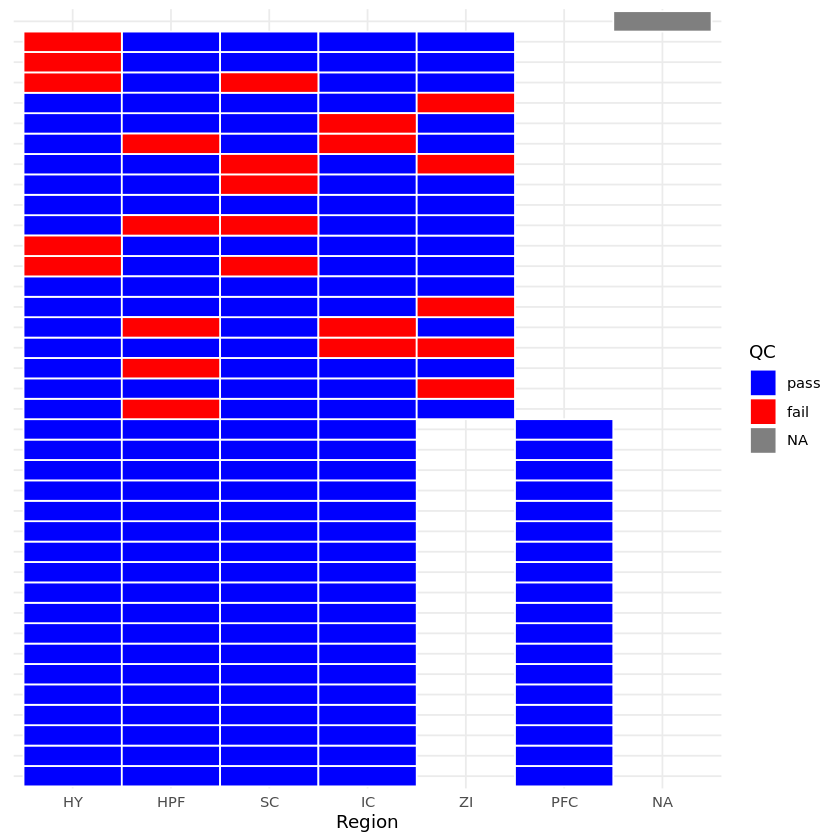

In [10]:
# Define the order of samples for the y-axis
sample_order <- meta_long %>%
arrange(seq_run, diet, region, animal_id) %>%
select(seq_run, diet, region, animal_id) %>%
distinct(animal_id) %>%
pull(animal_id) %>% as.character
sample_order

# Map the categorical variables to the plot
plot <- ggplot(meta_long, aes(x = region, y = animal_id, fill = (seq_run == "0038"))) +
  geom_tile(color = "white", size = 0.5) +
  scale_fill_manual(values = c("blue", "red"), labels = c("pass", "fail")) +
  scale_y_discrete(limits = sample_order) +
  labs(x = "Region", y = "Sample", fill = "QC") +
  theme_minimal() +
  theme(axis.title.y = element_blank(), 
        axis.text.y = element_blank(),
#         legend.position = "none")
        )
plot

In [11]:
column_order_animal = c("box_id", "animal_id", "diet", "diet_kcal",
"experiment_start", "time_of_euthanasia", "experiment_duration", 
'bw_i_pre', "bw_i", "bw_f", "bw_change", "bw_change_pct", "bw_change_pct_ph",  
"fw_i", "fw_f", "kcal_intake", "power_intake", 
"notes")

meta_animal = meta_long %>%
select(all_of(column_order_animal)) %>%
distinct

meta_animal

box_id,animal_id,diet,diet_kcal,experiment_start,time_of_euthanasia,experiment_duration,bw_i_pre,bw_i,bw_f,bw_change,bw_change_pct,bw_change_pct_ph,fw_i,fw_f,kcal_intake,power_intake,notes
<chr>,<fct>,<fct>,<dbl>,<dttm>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
34,1,chow,3227,2019-01-29 16:26:00,2019-01-30 08:26:00,16.00000,NA,23.4,24.6,1.2,0.051282051,0.0032051282,741.7,734.4,11778.55,736.1594,NA
34,2,chow,3227,2019-01-29 16:26:00,2019-01-30 08:36:00,16.16667,NA,25.9,26.0,0.1,0.003861004,0.0002388250,741.7,734.4,11778.55,728.5701,NA
35,3,chow,3227,2019-01-29 17:31:00,2019-01-30 09:31:00,16.00000,NA,26.2,26.4,0.2,0.007633588,0.0004770992,743.5,735.3,13230.70,826.9188,NA
35,4,chow,3227,2019-01-29 17:31:00,2019-01-30 09:41:00,16.16667,NA,23.5,24.0,0.5,0.021276596,0.0013160781,743.5,735.3,13230.70,818.3938,NA
36,5,chow,3227,2019-01-29 18:27:00,2019-01-30 10:27:00,16.00000,NA,24.7,24.4,-0.3,-0.012145749,-0.0007591093,713.6,706.4,11617.20,726.0750,NA
36,6,chow,3227,2019-01-29 18:27:00,2019-01-30 10:33:00,16.10000,NA,25.9,27.0,1.1,0.042471042,0.0026379529,713.6,706.4,11617.20,721.5652,NA
37,7,fast,0,2019-01-29 16:49:00,2019-01-30 08:49:00,16.00000,NA,23.9,23.3,-0.6,-0.025104603,-0.0015690377,0.0,0.0,0.00,0.0000,NA
37,8,fast,0,2019-01-29 16:49:00,2019-01-30 08:59:00,16.16667,NA,23.1,22.8,-0.3,-0.012987013,-0.0008033204,0.0,0.0,0.00,0.0000,NA
38,9,fast,0,2019-01-29 17:50:00,2019-01-30 09:50:00,16.00000,NA,24.1,23.5,-0.6,-0.024896266,-0.0015560166,0.0,0.0,0.00,0.0000,NA


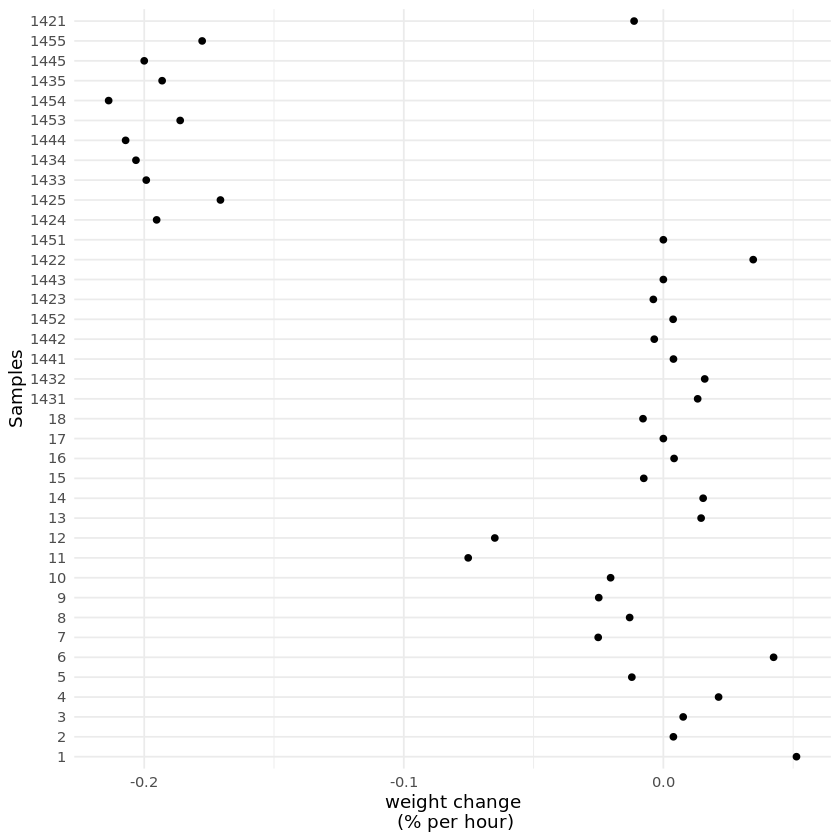

In [12]:
# Convert the name column to a factor with the desired order
meta_animal$animal_id <- factor(meta_animal$animal_id, levels = sample_order)

# Create the dot plot
plot_2 = ggplot(meta_animal, aes(y = animal_id, x = bw_change_pct)) +
  geom_point() +
  labs(x = "weight change\n (% per hour)", y = "Samples") +
  theme_minimal()

plot_2

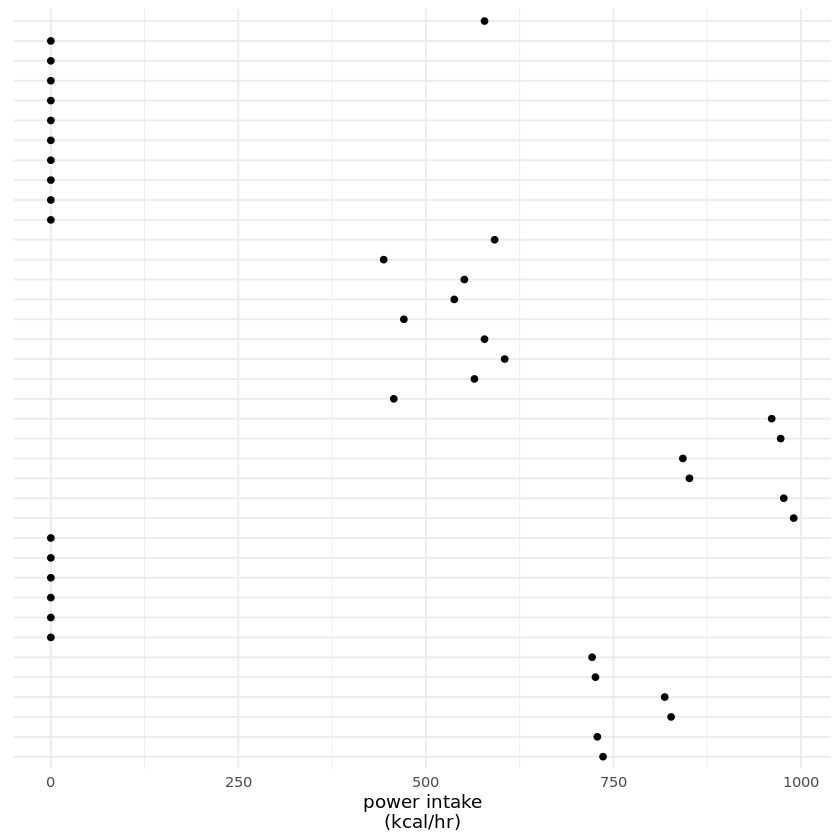

In [13]:
# Convert the name column to a factor with the desired order
meta_animal$animal_id <- factor(meta_animal$animal_id, levels = sample_order)

# Create the dot plot
plot_3 = ggplot(meta_animal, aes(y = animal_id, x = power_intake)) +
  geom_point() +
  labs(x = "power intake\n(kcal/hr)", y = "Samples") +
  theme_minimal() +
  theme(axis.title.y = element_blank(), 
        axis.text.y = element_blank(),
        legend.position = "none")

plot_3

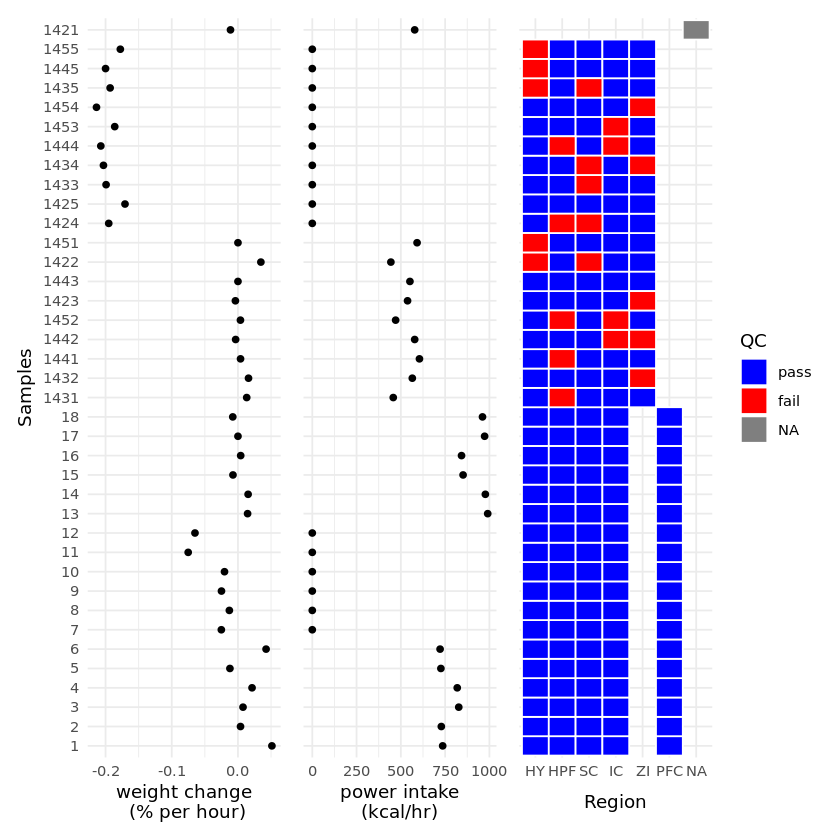

In [14]:
plot_2 + plot_3 + plot

In [15]:
meta_long

filename,name,seq_run,seq_sample,rna_conc_qbit,box_id,animal_id,diet,diet_kcal,region,⋯,bw_i,bw_f,bw_change,bw_change_pct,bw_change_pct_ph,fw_i,fw_f,kcal_intake,power_intake,notes
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>,<fct>,<dbl>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1_Chow_Hyp_both_S80,S0010_01_chow_HY,0010,S80,73.600,34,1,chow,3227,HY,⋯,23.4,24.6,1.2,0.051282051,0.0032051282,741.7,734.4,11778.55,736.1594,NA
2_Chow_Hyp_both_S44,S0010_02_chow_HY,0010,S44,27.200,34,2,chow,3227,HY,⋯,25.9,26.0,0.1,0.003861004,0.0002388250,741.7,734.4,11778.55,728.5701,NA
3_Chow_Hyp_both_S78,S0010_03_chow_HY,0010,S78,6.360,35,3,chow,3227,HY,⋯,26.2,26.4,0.2,0.007633588,0.0004770992,743.5,735.3,13230.70,826.9188,NA
4_Chow_Hyp_both_S25,S0010_04_chow_HY,0010,S25,20.800,35,4,chow,3227,HY,⋯,23.5,24.0,0.5,0.021276596,0.0013160781,743.5,735.3,13230.70,818.3938,NA
5_Chow_Hyp_both_S84,S0010_05_chow_HY,0010,S84,20.400,36,5,chow,3227,HY,⋯,24.7,24.4,-0.3,-0.012145749,-0.0007591093,713.6,706.4,11617.20,726.0750,NA
6_Chow_Hyp_both_S66,S0010_06_chow_HY,0010,S66,10.600,36,6,chow,3227,HY,⋯,25.9,27.0,1.1,0.042471042,0.0026379529,713.6,706.4,11617.20,721.5652,NA
1_Chow_Hip_left_S17,S0010_01_chow_HPF,0010,S17,17.600,34,1,chow,3227,HPF,⋯,23.4,24.6,1.2,0.051282051,0.0032051282,741.7,734.4,11778.55,736.1594,NA
2_Chow_Hip_left_S71,S0010_02_chow_HPF,0010,S71,38.800,34,2,chow,3227,HPF,⋯,25.9,26.0,0.1,0.003861004,0.0002388250,741.7,734.4,11778.55,728.5701,NA
3_Chow_Hip_left_S4,S0010_03_chow_HPF,0010,S4,44.600,35,3,chow,3227,HPF,⋯,26.2,26.4,0.2,0.007633588,0.0004770992,743.5,735.3,13230.70,826.9188,NA


In [16]:
# Define the function
aggregate_counts <- function(meta_long) {
  
    
  # Initialize an empty list to store individual count data frames
  count_dfs <- list()
  
  # Iterate over each row in the metadata tibble
  for (i in 1:nrow(meta_long)) {
    
    # Construct the filepath from the seq_run and filename
    filepath <- paste0("../data/02_aligned/", meta_long$seq_run[i], "/", 
                       meta_long$filename[i], "_ReadsPerGene.out.tab")
    
    # Read the file into a tibble
    file_df <- read_tsv(filepath, col_names = c("gene", "unstranded", "stranded1", "stranded2"))
    
    # Filter out rows that don't correspond to a gene (based on pattern)
    file_df <- file_df %>% 
      filter(str_detect(gene, "^ENSMUSG")) %>% 
      select(gene, unstranded)  # or select the column you need
    
    # Rename the count column to match the name from the metadata
    colnames(file_df)[2] <- meta_long$name[i]
    
    # Add this count data frame to the list
    count_dfs[[i]] <- file_df
  }
  
  # Join all the count data frames by gene
  count_df <- reduce(count_dfs, left_join, by = "gene")
  
  # Return the combined count data frame
  return(count_df)
}

# Usage
combined_counts <- meta_long %>% filter(!is.na(filename)) %>% aggregate_counts
combined_counts %>% head


Rows: 57014 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene
dbl (3): unstranded, stranded1, stranded2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 57014 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene
dbl (3): unstranded, stranded1, stranded2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 57014 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene
dbl (3): unstranded, stranded1, stranded2

ℹ Use `spec()` to retrieve the full colum

gene,S0010_01_chow_HY,S0010_02_chow_HY,S0010_03_chow_HY,S0010_04_chow_HY,S0010_05_chow_HY,S0010_06_chow_HY,S0010_01_chow_HPF,S0010_02_chow_HPF,S0010_03_chow_HPF,⋯,S0038_1424_fast_HPF,S0038_1444_fast_HPF,S0038_1424_fast_SC,S0038_1433_fast_SC,S0038_1434_fast_SC,S0038_1435_fast_SC,S0038_1444_fast_IC,S0038_1453_fast_IC,S0038_1434_fast_ZI,S0038_1454_fast_ZI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000104478,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000104385,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000086053,41,49,37,19,23,22,22,53,34,⋯,0,2,0,1,13,4,0,2,0,0
ENSMUSG00000101231,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000102135,1,5,0,0,0,0,0,0,0,⋯,6,3,0,1,2,2,4,11,5,4
ENSMUSG00000103282,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [17]:
meta_long %>% colnames

[1] "filename"            "name"                "seq_run"             "seq_sample"          "rna_conc_qbit"      
 [6] "box_id"              "animal_id"           "diet"                "diet_kcal"           "region"             
[11] "hemisphere"          "experiment_start"    "time_of_euthanasia"  "experiment_duration" "bw_i_pre"           
[16] "bw_i"                "bw_f"                "bw_change"           "bw_change_pct"       "bw_change_pct_ph"   
[21] "fw_i"                "fw_f"                "kcal_intake"         "power_intake"        "notes"

In [18]:
meta_long %>% write_csv('meta_long.csv', )
meta_animal %>% write_csv('meta_animal.csv')
combined_counts %>% write_csv('counts.csv')

In [22]:
meta_long %>% distinct(animal_id, region, hemisphere, seq_run) %>% group_by(animal_id, region, hemisphere, seq_run) %>% summarise(n = n())

`summarise()` has grouped output by 'animal_id', 'region', 'hemisphere'. You can override using the `.groups` argument.


animal_id,region,hemisphere,seq_run,n
<fct>,<fct>,<chr>,<chr>,<int>
1,HY,both,0010,1
1,HPF,left,0010,1
1,SC,left,0010,1
1,IC,left,0010,1
1,PFC,left,0010,1
2,HY,both,0010,1
2,HPF,left,0010,1
2,SC,left,0010,1
2,IC,left,0010,1


In [24]:
meta_long %>% filter(seq_run %in% c('0037', '0038')) %>% distinct(seq_run, name) 

seq_run,name
<chr>,<chr>
0037,S0037_1431_chow_HY
0037,S0037_1432_chow_HY
0037,S0037_1441_chow_HY
0037,S0037_1442_chow_HY
0037,S0037_1452_chow_HY
0037,S0037_1423_chow_HY
0037,S0037_1443_chow_HY
0037,S0037_1422_chow_HPF
0037,S0037_1432_chow_HPF


In [26]:
meta_long %>% colnames %>% dput

c("filename", "name", "seq_run", "seq_sample", "rna_conc_qbit", 
"box_id", "animal_id", "diet", "diet_kcal", "region", "hemisphere", 
"experiment_start", "time_of_euthanasia", "experiment_duration", 
"bw_i_pre", "bw_i", "bw_f", "bw_change", "bw_change_pct", "bw_change_pct_ph", 
"fw_i", "fw_f", "kcal_intake", "power_intake", "notes")


In [27]:
meta_long %>% head

filename,name,seq_run,seq_sample,rna_conc_qbit,box_id,animal_id,diet,diet_kcal,region,⋯,bw_i,bw_f,bw_change,bw_change_pct,bw_change_pct_ph,fw_i,fw_f,kcal_intake,power_intake,notes
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<fct>,<fct>,<dbl>,<fct>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1_Chow_Hyp_both_S80,S0010_01_chow_HY,0010,S80,73.60,34,1,chow,3227,HY,⋯,23.4,24.6,1.2,0.051282051,0.0032051282,741.7,734.4,11778.55,736.1594,NA
2_Chow_Hyp_both_S44,S0010_02_chow_HY,0010,S44,27.20,34,2,chow,3227,HY,⋯,25.9,26.0,0.1,0.003861004,0.0002388250,741.7,734.4,11778.55,728.5701,NA
3_Chow_Hyp_both_S78,S0010_03_chow_HY,0010,S78,6.36,35,3,chow,3227,HY,⋯,26.2,26.4,0.2,0.007633588,0.0004770992,743.5,735.3,13230.70,826.9188,NA
4_Chow_Hyp_both_S25,S0010_04_chow_HY,0010,S25,20.80,35,4,chow,3227,HY,⋯,23.5,24.0,0.5,0.021276596,0.0013160781,743.5,735.3,13230.70,818.3938,NA
5_Chow_Hyp_both_S84,S0010_05_chow_HY,0010,S84,20.40,36,5,chow,3227,HY,⋯,24.7,24.4,-0.3,-0.012145749,-0.0007591093,713.6,706.4,11617.20,726.0750,NA
6_Chow_Hyp_both_S66,S0010_06_chow_HY,0010,S66,10.60,36,6,chow,3227,HY,⋯,25.9,27.0,1.1,0.042471042,0.0026379529,713.6,706.4,11617.20,721.5652,NA
